In [1]:
!pip install pandas yfinance numpy matplotlib scikit-learn seaborn tensorflow torch

Kullanılan Cihaz: cpu
1. GRU MODELİ İÇİN VERİ HAZIRLANIYOR...

2. GRU EĞİTİMİ BAŞLIYOR...


/var/folders/xl/_cnln_n95bq4hsnmlbfd4_vw0000gn/T/ipykernel_53338/563245301.py:31: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('BTC-USD', start=start_date, end=end_date, progress=False, threads=False)


   Epoch 10: Loss 0.00570
   Epoch 20: Loss 0.00309
   Epoch 30: Loss 0.00116
   Epoch 40: Loss 0.00071
   Epoch 50: Loss 0.00052
   Epoch 60: Loss 0.00049
   Epoch 70: Loss 0.00047
   Epoch 80: Loss 0.00045
   Epoch 90: Loss 0.00047
   Epoch 100: Loss 0.00040
   Epoch 110: Loss 0.00042
   Epoch 120: Loss 0.00040
   Epoch 130: Loss 0.00039
   Epoch 140: Loss 0.00041
   Epoch 150: Loss 0.00041

3. METRİKLER HESAPLANIYOR...
   • Metrikler kaydedildi: gru_metrics.csv

4. GELECEK SİMÜLASYONU...
   • Gelecek tahminleri kaydedildi.

5. GRAFİKLER KAYDEDİLİYOR...

✓ GRU MODELİ TAMAMLANDI. Dosyaları kontrol edin.


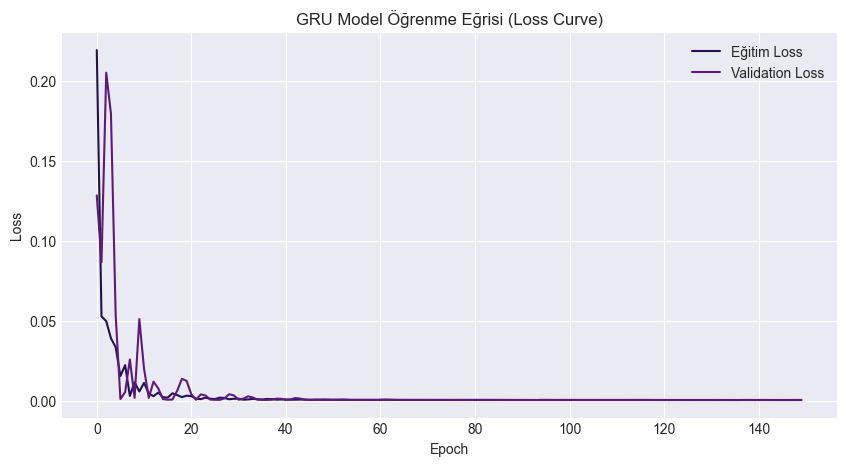

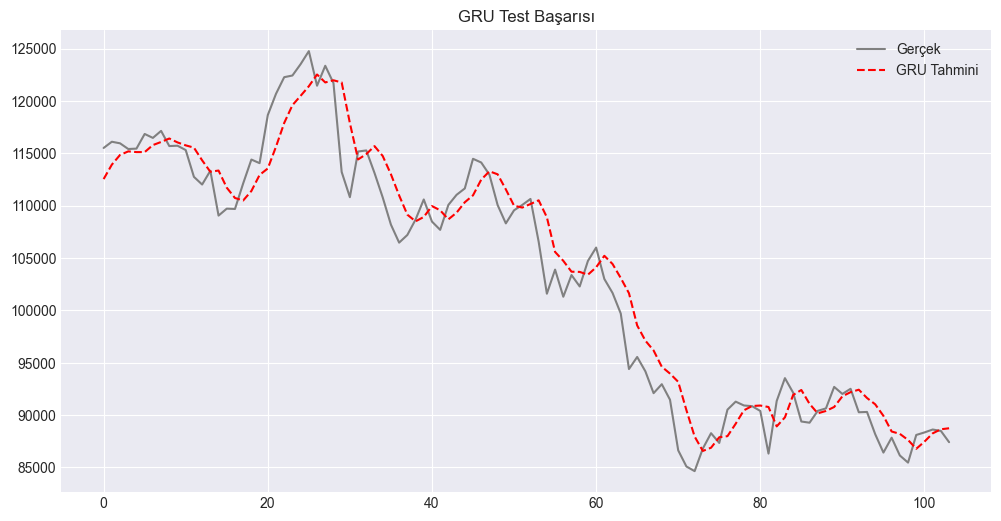

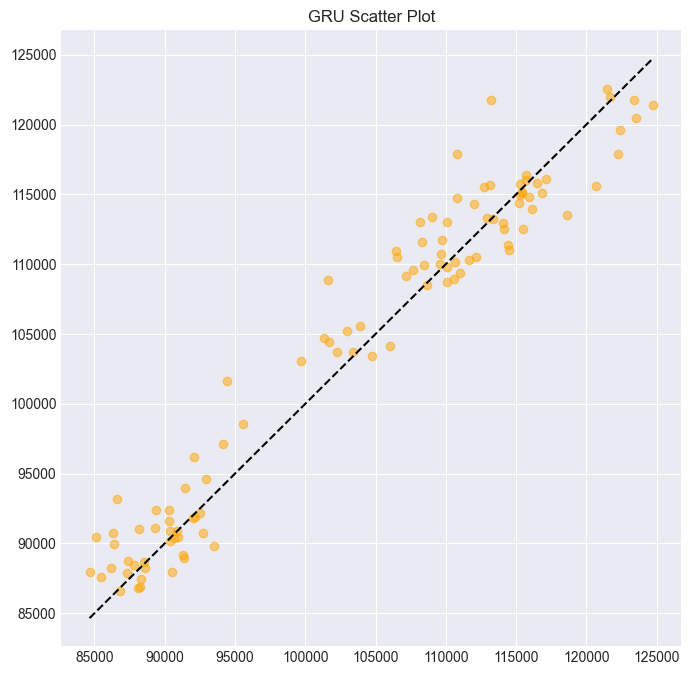

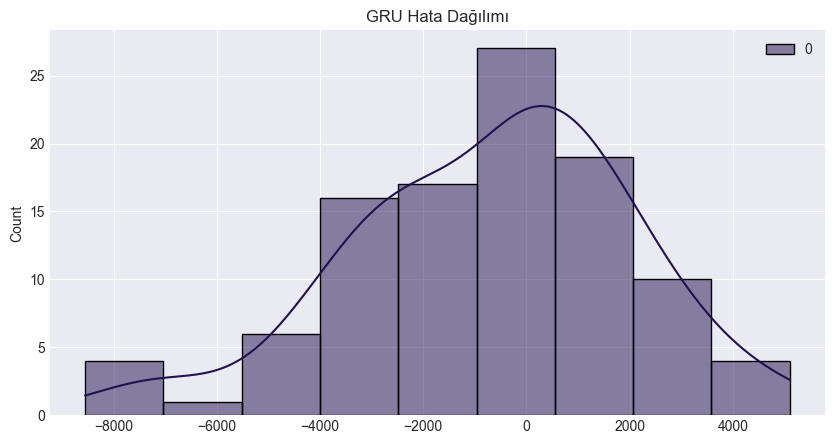

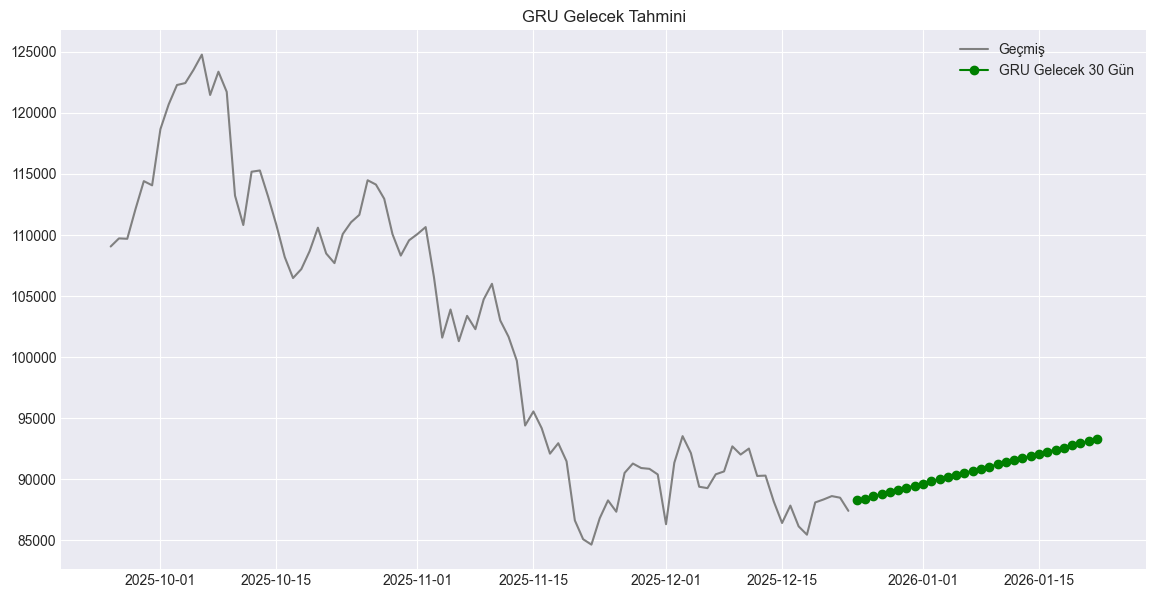

In [2]:
# =============================================================================
# MODEL 2: PYTORCH GRU (Düzeltilmiş Final Versiyon)
# =============================================================================

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from datetime import date, timedelta
import copy

# Ayarlar
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("magma")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Kullanılan Cihaz: {device}")

# 1. VERİ HAZIRLAMA
print("1. GRU MODELİ İÇİN VERİ HAZIRLANIYOR...")
today = date.today()
end_date = today.strftime("%Y-%m-%d")
start_date = (today - timedelta(days=1095)).strftime("%Y-%m-%d")

try:
    df = yf.download('BTC-USD', start=start_date, end=end_date, progress=False, threads=False)
    if isinstance(df.columns, pd.MultiIndex): df.columns = df.columns.get_level_values(0)
    df.reset_index(inplace=True)
except:
    df = pd.DataFrame()

# Veri kontrolü
if df.empty:
    print("HATA: Veri indirilemedi. İnternet bağlantınızı kontrol edin.")
else:
    data = df[['Close']].values.astype(float)
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data)

    def create_sequences(data, seq_length):
        xs, ys = [], []
        for i in range(len(data) - seq_length):
            xs.append(data[i:i+seq_length])
            ys.append(data[i+seq_length])
        return np.array(xs), np.array(ys)

    SEQ_LENGTH = 60
    X, y = create_sequences(data_scaled, SEQ_LENGTH)

    train_size = int(len(X) * 0.8)
    val_size = int(len(X) * 0.1)
    X_train, y_train = X[:train_size], y[:train_size]
    X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
    X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

    def to_tensor(arr): return torch.from_numpy(arr).float().to(device)
    X_train, y_train = to_tensor(X_train), to_tensor(y_train)
    X_val, y_val = to_tensor(X_val), to_tensor(y_val)
    X_test, y_test = to_tensor(X_test), to_tensor(y_test)

    # 2. GRU MODEL SINIFI (DÜZELTİLDİ)
    class GRUModel(nn.Module):
        def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout_prob):
            super(GRUModel, self).__init__()
            # --- EKSİK OLAN KISIM EKLENDİ ---
            self.hidden_dim = hidden_dim
            self.num_layers = num_layers
            # --------------------------------
            
            # GRU Katmanı
            self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout_prob)
            self.fc = nn.Linear(hidden_dim, output_dim)
        
        def forward(self, x):
            # Artık self.num_layers ve self.hidden_dim tanındığı için hata vermeyecek
            h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
            out, _ = self.gru(x, h0)
            out = out[:, -1, :]
            out = self.fc(out)
            return out

    # 3. EĞİTİM
    print("\n2. GRU EĞİTİMİ BAŞLIYOR...")
    PARAMS = {'hidden_dim': 128, 'num_layers': 2, 'lr': 0.005, 'dropout': 0.1}

    model = GRUModel(1, PARAMS['hidden_dim'], PARAMS['num_layers'], 1, PARAMS['dropout']).to(device)
    optimizer = optim.Adam(model.parameters(), lr=PARAMS['lr'])
    criterion = nn.MSELoss()

    train_losses, val_losses = [], []
    min_val_loss = float('inf')
    patience, counter = 20, 0
    best_wts = None

    for epoch in range(150):
        model.train()
        optimizer.zero_grad()
        out = model(X_train)
        loss = criterion(out, y_train)
        loss.backward()
        optimizer.step()
        
        model.eval()
        with torch.no_grad():
            val_out = model(X_val)
            val_loss = criterion(val_out, y_val).item()
            
        train_losses.append(loss.item())
        val_losses.append(val_loss)
        
        if val_loss < min_val_loss:
            min_val_loss = val_loss
            counter = 0
            best_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), 'gru_best.pth')
        else:
            counter += 1
            if counter >= patience:
                print(f"   Early Stopping: Epoch {epoch}")
                break
                
        if (epoch+1) % 10 == 0:
            print(f"   Epoch {epoch+1}: Loss {loss.item():.5f}")

    if best_wts:
        model.load_state_dict(best_wts)

    # 4. METRİKLER VE DOSYALAMA
    print("\n3. METRİKLER HESAPLANIYOR...")
    model.eval()
    with torch.no_grad():
        preds = model(X_test).cpu().numpy()
        targets = y_test.cpu().numpy()

    preds_inv = scaler.inverse_transform(preds)
    targets_inv = scaler.inverse_transform(targets)

    metrics = {
        "R2": r2_score(targets_inv, preds_inv),
        "RMSE": np.sqrt(mean_squared_error(targets_inv, preds_inv)),
        "MAE": mean_absolute_error(targets_inv, preds_inv),
        "MAPE": mean_absolute_percentage_error(targets_inv, preds_inv)
    }
    pd.DataFrame([metrics]).to_csv("gru_metrics.csv", index=False)
    print("   • Metrikler kaydedildi: gru_metrics.csv")

    # 5. GELECEK 30 GÜN TAHMİNİ
    print("\n4. GELECEK SİMÜLASYONU...")
    last_sequence = data_scaled[-SEQ_LENGTH:]
    current_seq = torch.from_numpy(last_sequence).float().to(device).unsqueeze(0)

    future_preds = []
    for _ in range(30):
        with torch.no_grad():
            pred = model(current_seq)
            future_preds.append(pred.item())
            new_pred = pred.unsqueeze(1)
            current_seq = torch.cat((current_seq[:, 1:, :], new_pred), dim=1)

    future_preds_inv = scaler.inverse_transform(np.array(future_preds).reshape(-1, 1))

    last_date_obj = pd.to_datetime(df['Date'].iloc[-1])
    future_dates = [last_date_obj + timedelta(days=x) for x in range(1, 31)]
    forecast_df = pd.DataFrame({'Date': future_dates, 'Forecast': future_preds_inv.flatten()})
    forecast_df.to_csv('gru_future_predictions.csv', index=False)
    print("   • Gelecek tahminleri kaydedildi.")

    # 6. GÖRSELLEŞTİRME (FULL SET)
    print("\n5. GRAFİKLER KAYDEDİLİYOR...")

    # Grafik 1: Loss Curve
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Eğitim Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('GRU Model Öğrenme Eğrisi (Loss Curve)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('gru_1_loss_curve.png')

    # Grafik 2: Test Prediction
    plt.figure(figsize=(12, 6))
    plt.plot(targets_inv, label='Gerçek', color='gray')
    plt.plot(preds_inv, label='GRU Tahmini', color='red', linestyle='--')
    plt.title('GRU Test Başarısı')
    plt.legend()
    plt.savefig('gru_2_test_prediction.png')

    # Grafik 3: Scatter
    plt.figure(figsize=(8, 8))
    plt.scatter(targets_inv, preds_inv, alpha=0.5, color='orange')
    plt.plot([targets_inv.min(), targets_inv.max()], [targets_inv.min(), targets_inv.max()], 'k--')
    plt.title('GRU Scatter Plot')
    plt.savefig('gru_3_scatter.png')

    # Grafik 4: Residuals
    plt.figure(figsize=(10, 5))
    sns.histplot(targets_inv - preds_inv, kde=True, color='brown')
    plt.title('GRU Hata Dağılımı')
    plt.savefig('gru_4_residuals.png')

    # Grafik 5: Future
    plt.figure(figsize=(14, 7))
    hist_dates = df['Date'].iloc[-90:]
    hist_vals = df['Close'].iloc[-90:]
    plt.plot(hist_dates, hist_vals, label='Geçmiş', color='gray')
    plt.plot(forecast_df['Date'], forecast_df['Forecast'], label='GRU Gelecek 30 Gün', color='green', marker='o')
    plt.title('GRU Gelecek Tahmini')
    plt.legend()
    plt.savefig('gru_5_future.png')

    print("\n✓ GRU MODELİ TAMAMLANDI. Dosyaları kontrol edin.")